#  <font color='red'> Bayesian Classification </font> 

We obtain the probability distribution of the line parameters rather than scalar estimates of slope and y intercept.
 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import scipy as sc
from scipy.stats import multivariate_normal
import pandas as pd

plt.rcParams.update({'font.size': 16})
#plt.rcParams['figure.figsize'] = [6, 3]


## Reading the data

In [2]:
fname = 'fishes.csv'
data = pd.read_csv(fname)
data.head(10)

,Fishtype,lightness,length
0,1.0,2.220252,-1.603168
1,1.0,3.771725,-3.621082
2,1.0,2.898739,-3.625635
3,1.0,4.484533,-1.227532
4,1.0,1.005928,-3.027846
5,0.0,-0.611962,0.252595
6,0.0,-1.617321,-0.085127
7,0.0,-1.086477,0.932646
8,1.0,2.255999,-2.207233
9,1.0,4.633921,-3.386524


## Extracting the different features

In [3]:
# Exctracting the fields with Fishtype=1 (bass)
bass = data[data["Fishtype"] == 1]
basslightness = bass['lightness'].to_numpy()
basslength = bass['length'].to_numpy()
basscount = bass['lightness'].count()

# Exctracting the fields with Fishtype=0 (salmon)
salmon = data[data["Fishtype"] == 0]
salmonlightness = salmon['lightness'].to_numpy()
salmonlength = salmon['length'].to_numpy()
salmoncount = salmon['lightness'].count()

print(basscount)
print(salmoncount)

32304
18203


## Estimation of the probability densities

We will rely on histograms to estimate the conditional probability densities $p({\rm lightness}|{\rm bass})$, $p({\rm lightness}|{\rm salmon})$

The prior probabilities $p({\rm salmon})$ from the training data as 

$$p({\rm salmon}) = \frac{N_{\rm salmon}}{N_{\rm bass} + N_{\rm salmon}}$$

and similarly 

$$p({\rm bass}) = \frac{N_{\rm bass}}{N_{\rm bass} + N_{\rm salmon}}$$

The joint probabilities can be evaluated as 

$$p({\rm salmon,lightness}) = p({\rm lightness|salmon})p({\rm salmon})$$

and 

$$p({\rm bass,lightness}) = p({\rm lightness|bass})p({\rm bass})$$

The marginal $p({\rm lightness})$ can be obtained using the sum rule as 

$$p({\rm lightness}) = p({\rm bass,lightness})+p({\rm salmon,lightness})$$


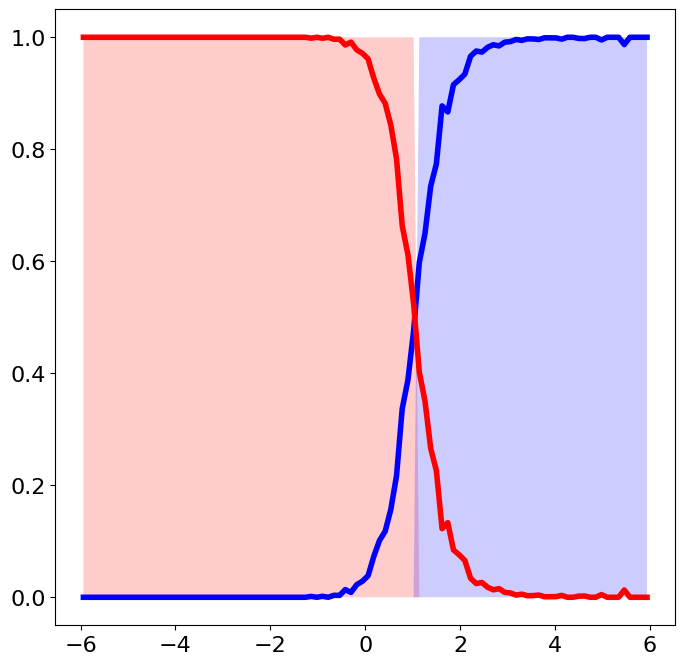

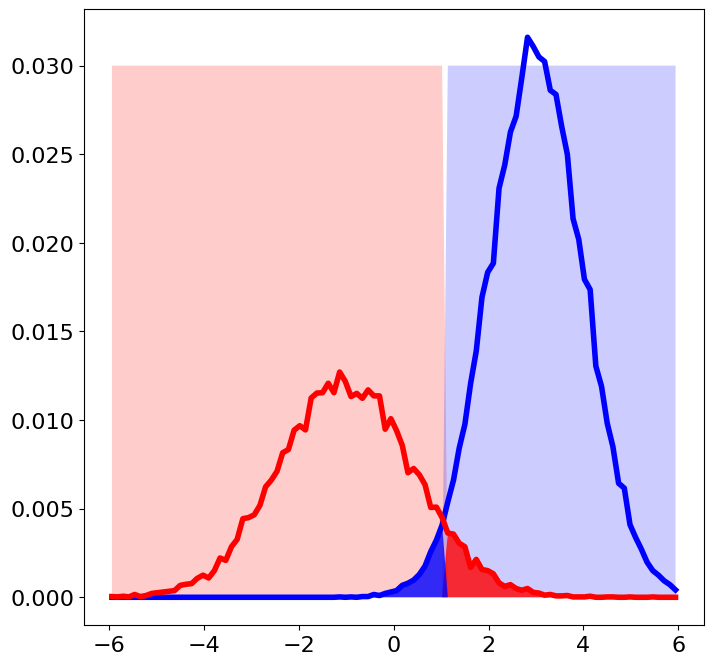

In [13]:
Nbins = 100
bins = np.linspace(-6,6,Nbins+1)
bincenters = (bins[0:Nbins]+bins[1:Nbins+1])/2


# Conditional probabilities
p_l_given_salmon,bc = np.histogram(salmonlightness, bins=bins)
p_l_given_bass,bc = np.histogram(basslightness, bins=bins)

p_l_given_bass = p_l_given_bass/basscount
p_l_given_salmon = p_l_given_salmon/salmoncount

# Priors
pbass = basscount/(basscount+salmoncount)
psalmon = salmoncount/(basscount+salmoncount)

# Joint probabilities
p_l_and_bass = p_l_given_bass*pbass
p_l_and_salmon = p_l_given_salmon*psalmon

# Evidence
p_lightness = p_l_and_bass + p_l_and_salmon
p_lightness = p_lightness + 1e-8*(p_lightness==0)

# Posterior probabilities: Bayes estimate

p_bass_given_l = p_l_given_bass*pbass/p_lightness
p_salmon_given_l = p_l_given_salmon*psalmon/p_lightness

# PLOTTING THE PROBABILITIES
#---------------------------
fig = plt.figure(figsize=[8,8])
s=plt.plot(bincenters,p_bass_given_l,'b',label='$p(bass|lightness)$',linewidth=4)
s=plt.plot(bincenters,p_salmon_given_l,'r',label='$p(salmon|lightness)$',linewidth=4)

bass_region = p_bass_given_l > p_salmon_given_l
salmon_region = p_bass_given_l <= p_salmon_given_l

s=plt.fill_between(bincenters,salmon_region,label='$salmon: R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass: R_2$',facecolor='blue', alpha=0.2)


fig = plt.figure(figsize=[8,8])
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(lightness,salmon)',linewidth=4)

# TODO: Compute the salmon region
bass_region = (p_l_and_bass > p_l_and_salmon)
salmon_region = (p_l_and_bass <= p_l_and_salmon)  # Regions where salmon is more probable

# TODO: Compute the salmon error
bass_err = p_l_and_bass*salmon_region
salmon_err = p_l_and_salmon * bass_region  # Error: when salmon region incorrectly contains bass

bass_region = 0.03*bass_region
salmon_region = 0.03*salmon_region
s=plt.fill_between(bincenters,salmon_region,label='$salmon:  R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass:  R_2 $',facecolor='blue', alpha=0.2)


s=plt.fill_between(bincenters,salmon_err,0*salmon_err,label='Error:salmon',facecolor='red', alpha=0.8)
s=plt.fill_between(bincenters,bass_err,0*bass_err,label='Error:bass',facecolor='blue', alpha=0.8)



# Reject option to reduce error 

Bayes classification relies on the decision boundary 

$$p({\rm bass}|l) > p({\rm salmon}|l)~:~~ l\rightarrow \rm bass$$

Note that the posteriors add up to one $p({\rm bass}|l)+ p({\rm salmon}|l)=1$. Combining the two equations, we get 

$$p({\rm bass}|l) > 1-p({\rm bass}|l) ~:~~ l\rightarrow \rm bass$$

or equivalently

$$p({\rm bass}|l) > \frac{1}{2} ~:~~ l\rightarrow \rm bass$$

The threshold of 0.5 results in high errors, close to the boundary. We can minimize the error by choosing more conservative thresholds

$$p({\rm bass}|l) > 0.85 ~:~~ l\rightarrow \rm bass$$
$$p({\rm salmon}|l) > 0.85 ~:~~ l\rightarrow \rm salmon$$


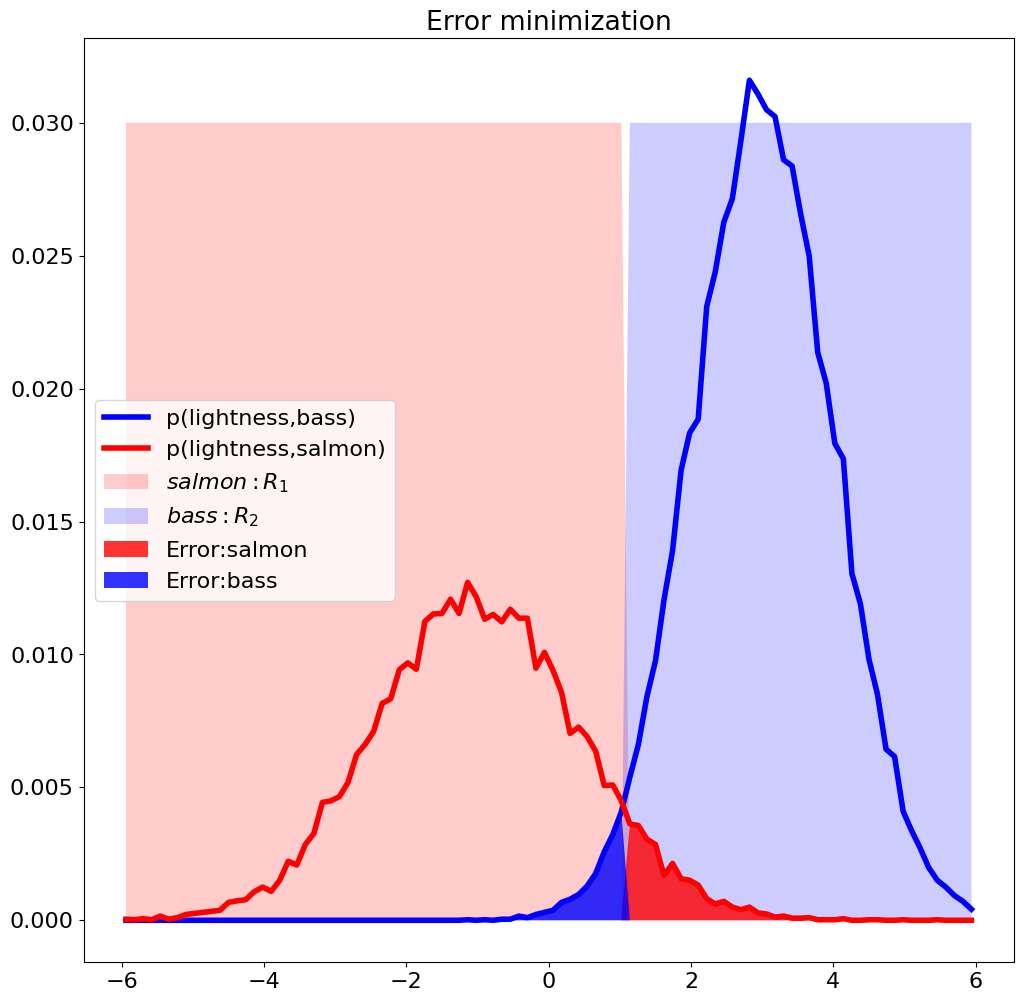

In [6]:
fig = plt.figure(figsize=[12,12])
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(lightness,salmon)',linewidth=4)

# TODO: add the code for the new salmon and bass regions
# Evaluate regions based on posterior probabilities
bass_region = (p_bass_given_l > p_salmon_given_l).astype(float)  # Regions where bass is more probable
salmon_region = (p_bass_given_l <= p_salmon_given_l).astype(float)  # Regions where salmon is more probable

# Calculate error regions (misclassified areas)
salmon_err = bass_region * p_l_and_salmon  # Error: when bass region incorrectly contains salmon
bass_err = salmon_region * p_l_and_bass  # Error: when salmon region incorrectly contains bass

bass_region = 0.03*bass_region
salmon_region = 0.03*salmon_region
s=plt.fill_between(bincenters,salmon_region,label='$salmon:  R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass:  R_2 $',facecolor='blue', alpha=0.2)


s=plt.fill_between(bincenters,salmon_err,0*salmon_err,label='Error:salmon',facecolor='red', alpha=0.8)
s=plt.fill_between(bincenters,bass_err,0*bass_err,label='Error:bass',facecolor='blue', alpha=0.8)
s = plt.title('Error minimization')
s = fig.gca().legend()



## Risk minimization


<font color = red>class 1: Salmon</font>

<font color = blue>class 2: Bass</font>

Risk in classifying <font color = red>class 1=Salmon</font> as <font color = red>class 1=Salmon</font>: $\lambda_{11}=0$

Risk in classifying <font color = red>class 1=Salmon</font> as <font color = blue>class 2 = Bass</font>: $\lambda_{12}=6$

Risk in classifying <font color = blue>class 2=Bass</font> as <font color = red>class 1=Salmon</font>: $\lambda_{21}=0.5$

Risk in classifying <font color = blue>class 2=Bass</font> as <font color = blue>class 2=Bass</font>: $\lambda_{22}=0$

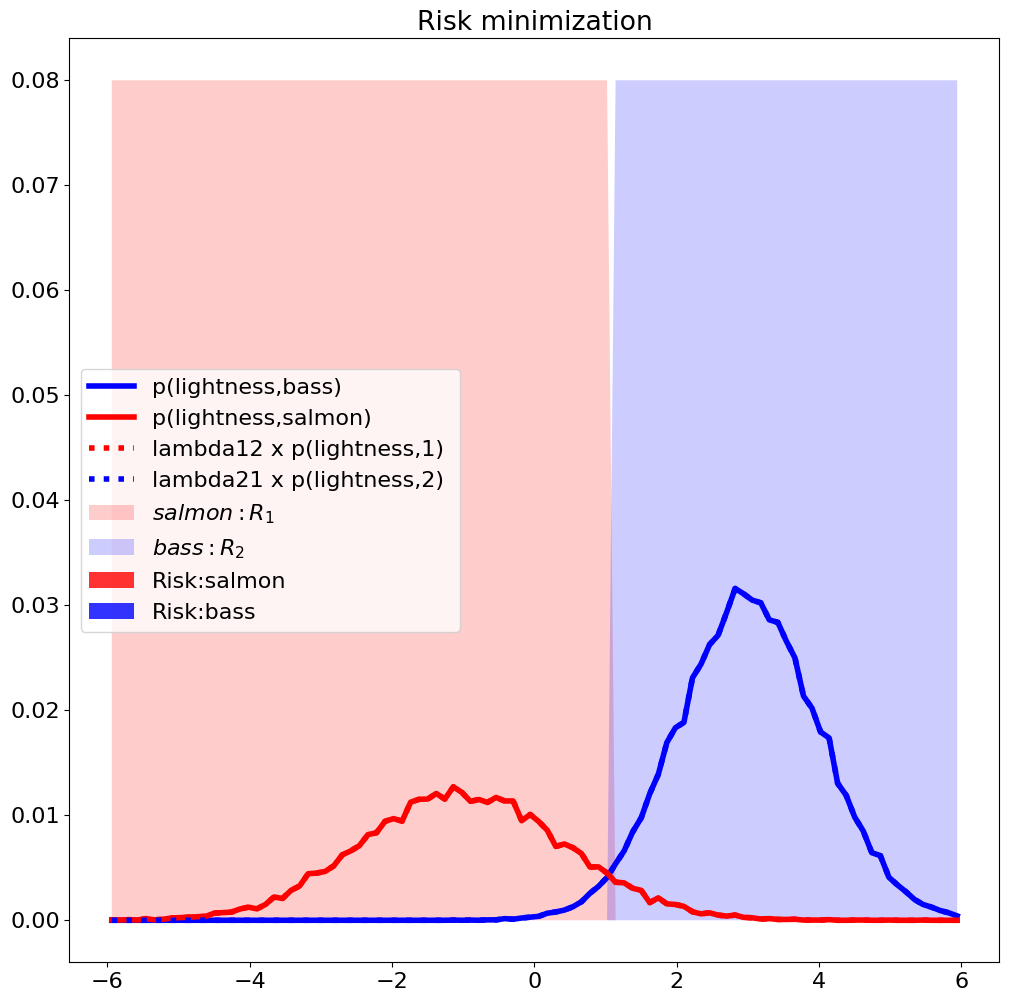

In [11]:
fig = plt.figure(figsize=[12,12])
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(lightness,salmon)',linewidth=4)

# TO DO -----------------------------------
# Compute weighted probabilities
lambda12 = 1  # Cost for misclassifying salmon as bass
lambda21 = 1  # Cost for misclassifying bass as salmon

lambda12_p1 = lambda12 * p_l_and_salmon  # Weighted joint probability for salmon
lambda21_p2 = lambda21 * p_l_and_bass    # Weighted joint probability for bass

# Evaluate the regions
salmon_region = lambda12_p1 > lambda21_p2
bass_region = lambda12_p1 <= lambda21_p2

#------------------------------------------
# Plotting 
salmon_err = 0*bincenters
bass_err = 0*bincenters

s=plt.plot(bincenters,lambda12_p1,'r:',label='lambda12 x p(lightness,1) ',linewidth=4)
s=plt.plot(bincenters,lambda21_p2,'b:',label='lambda21 x p(lightness,2)',linewidth=4)

bass_region = 0.08*bass_region
salmon_region = 0.08*salmon_region
s=plt.fill_between(bincenters,salmon_region,label='$salmon:  R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass:  R_2 $',facecolor='blue', alpha=0.2)


s=plt.fill_between(bincenters,salmon_err,0*salmon_err,label='Risk:salmon',facecolor='red', alpha=0.8)
s=plt.fill_between(bincenters,bass_err,0*bass_err,label='Risk:bass',facecolor='blue', alpha=0.8)
s = plt.title('Risk minimization')
s = fig.gca().legend()

